# FEV vs. RSA Analysis

For each VGG19 layer, this notebook plots **mean FEV** vs. **RSA (Spearman correlation)**.

- **Mean FEV** is taken from the regression: VGG19 features (reduced to N PCs) → Neural data (original dimensionality)

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

- The RSA class computes the **Spearman correlation** between RDMs of VGG19 features and neural data. Neural RDMs are built from full responses (correlation distance), and compared to feature RDMs to assess representational similarity 
  
- For features, dimensionality varies across VGG19 layers, so for each layer, the features are reduced to a fixed number of PCs (e.g. 50), to normalise

In [1]:
from cortexlib.utils import file as futils
from cortexlib.rsa import RSA
from cortexlib.utils.plotting import vgg19_colours
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.logging import Logger
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text
from tqdm.notebook import tqdm
import pandas as pd

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

15:31:34 | INFO     | ℹ️ This notebook is running for mouse m01_d2


In [3]:
# For each layer, results has an FEV score for predicting neural data from VGG19 features reduced to N PCs
# Load results and filter the best FEV per layer (e.g. feats reduced to optimal number of PCs)
fev_results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,NaN,0.407432,0.430933
5,conv3_4,NaN,0.416551,0.440492
10,conv4_4,NaN,0.396909,0.419901
15,conv5_4,NaN,0.281060,0.298454
20,fc2,NaN,0.266597,0.283292


In [4]:
vgg19_data = futils.load_model_features(futils.Model.VGG19, MOUSE_ID)
vgg19_feats = vgg19_data['features']

15:31:34 | INFO     | ℹ️ Loading model features from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m01_d2/_model_features/vgg19_features_mouse_m01_d2.pt


In [5]:
neural_data = futils.load_filtered_neural_data(MOUSE_ID)
neural_responses_mean = neural_data['neural_responses_mean']

15:31:34 | INFO     | ℹ️ Loading filtered neural data from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m01_d2/_neural_data/neural_data_mouse_m01_d2.pt


In [6]:
rsa = RSA(neural_data=neural_responses_mean, neural_data_pc_index=0)

pcs_list = [None, 10, 20, 50, 100]
rsa_results = []

logger.progress(f"Computing RSA: VGG19 features vs. PC1 neural data")
for layer, feats in tqdm(vgg19_feats.items(), desc="RSA all VGG19 layers"):
    logger.progress(f"VGG19 {layer}")
    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    
    for n_pcs in pcs_list:
        feats_pca = feats if n_pcs is None else PCA(n_pcs).fit_transform(feats)
        sim = rsa.compute_similarity_with_neural_data(feats_pca)
        rsa_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'spearman_correlation': sim,
        })

logger.success(f"RSA complete")

15:31:34 | INFO     | ⏳ Computing RSA: VGG19 features vs. PC1 neural data...


RSA all VGG19 layers:   0%|          | 0/5 [00:00<?, ?it/s]

15:31:34 | INFO     | ⏳ VGG19 conv2_2...
15:31:36 | INFO     | ⏳ VGG19 conv3_4...
15:31:37 | INFO     | ⏳ VGG19 conv4_4...
15:31:39 | INFO     | ⏳ VGG19 conv5_4...
15:31:42 | INFO     | ⏳ VGG19 fc2...
15:31:50 | SUCCESS  | ✅ RSA complete!


In [7]:
futils.write_json_file(rsa_results, './representational_similarity.json')

In [8]:
rsa_results_df = pd.DataFrame(rsa_results)
rsa_results_df.head(12)

,layer,n_pcs,spearman_correlation
0,conv2_2,NaN,0.152453
1,conv2_2,10.0,0.171830
2,conv2_2,20.0,0.168772
3,conv2_2,50.0,0.166901
4,conv2_2,100.0,0.166216
5,conv3_4,NaN,0.185882
6,conv3_4,10.0,0.200795
7,conv3_4,20.0,0.201196
8,conv3_4,50.0,0.201701
9,conv3_4,100.0,0.201766


In [9]:
# The dimensionality of features varies across model layers, so normalise it by the number of PCs used
rsa_pcs = rsa_results_df[rsa_results_df['n_pcs'] == 100].reset_index(drop=True)
rsa_pcs

,layer,n_pcs,spearman_correlation
0,conv2_2,100.0,0.166216
1,conv3_4,100.0,0.201766
2,conv4_4,100.0,0.169011
3,conv5_4,100.0,0.124517
4,fc2,100.0,0.106514


In [10]:
merged_results = pd.merge(best_fev_per_layer, rsa_pcs, on='layer')
merged_results

,layer,n_pcs_x,test_r2,mean_fev,n_pcs_y,spearman_correlation
0,conv2_2,NaN,0.407432,0.430933,100.0,0.166216
1,conv3_4,NaN,0.416551,0.440492,100.0,0.201766
2,conv4_4,NaN,0.396909,0.419901,100.0,0.169011
3,conv5_4,NaN,0.281060,0.298454,100.0,0.124517
4,fc2,NaN,0.266597,0.283292,100.0,0.106514


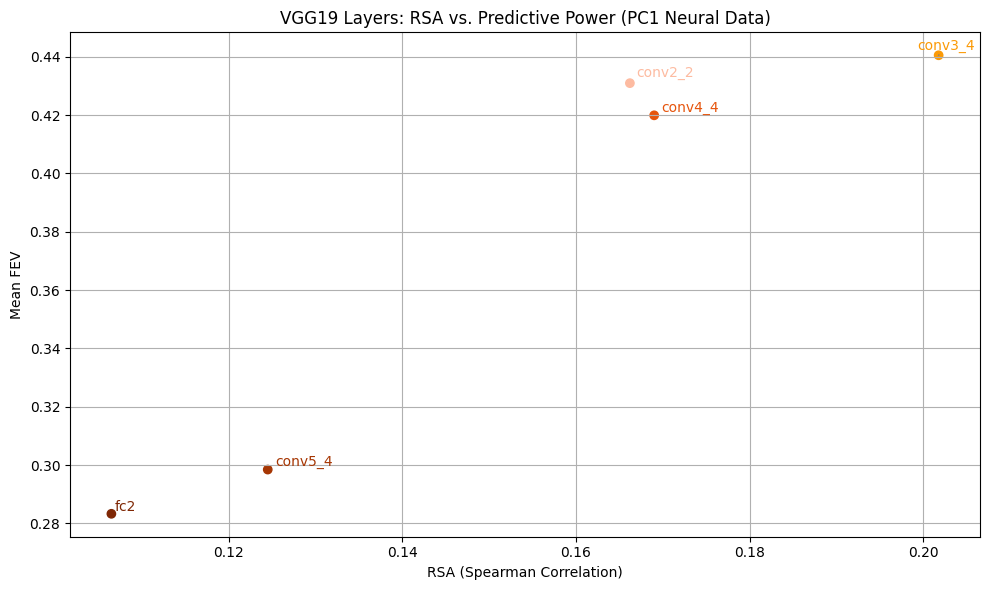

In [11]:
colours = merged_results['layer'].map(vgg19_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['spearman_correlation'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['spearman_correlation'], row['mean_fev'], row['layer'],
                 color=vgg19_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('RSA (Spearman Correlation)')
plt.ylabel('Mean FEV')
plt.title('VGG19 Layers: RSA vs. Predictive Power (PC1 Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()